In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def load_training():
    images = np.load(os.path.join('../../Data_final_fullver', 'X_train.npy'))
    labels = np.load(os.path.join('../../Data_final_fullver', 'train_labels3_num.npy'))
    filenames = np.load(os.path.join('../../Data_final_fullver', 'CBIS_train_FNs.npy'))
    return images, labels, filenames


def load_testing():
    images = np.load(os.path.join('../../Data_final_fullver', 'X_test.npy'))
    labels = np.load(os.path.join('../../Data_final_fullver', 'test_labels3_num.npy'))
    filenames = np.load(os.path.join('../../Data_final_fullver', 'CBIS_test_FNs.npy'))
    return images, labels, filenames

In [3]:
train_images, train_labels, Fn= load_training()
test_images, test_labels, Fn= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2925 	 Test size: 643
Image size: 256x256


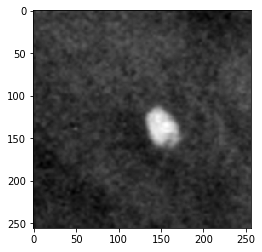

Label: 0
FN: Calc-Training_P_00455_LEFT_CC.png


In [4]:
idx = 3

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
print("FN: " + str(Fn[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(2925, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_vgg16(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(1024, activation='relu'))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(output, activation='softmax'))

    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [12]:
vgg = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in vgg.layers:
    layer.trainable = False
vgg_maxpool = vgg.get_layer('block5_pool').output
FeatureFlatten = Flatten()(vgg_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(4, name = 'predictions', activation = 'softmax')(dense2)

new_vgg = Model(inputs = vgg.input, outputs = predictions)
new_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [13]:
vgg16_calc_or_mass_best_Adam = new_vgg

In [14]:
vgg16_calc_or_mass_best_RMSprop = new_vgg

### Adam

In [22]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [23]:
# Train
history_vgg16_calc_or_mass_best_Adam = vgg16_calc_or_mass_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.0798 - recall: 0.2969
Epoch 00001: val_loss improved from inf to 1.26748, saving model to ../model/vgg16_calc_or_mass_best_Adam.h5
11/11 [==============================] - 25s 2s/step - loss: 2.0185 - recall: 0.2955 - val_loss: 1.2675 - val_recall: 0.2462
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2598 - recall: 0.2710
Epoch 00002: val_loss did not improve from 1.26748
11/11 [==============================] - 20s 2s/step - loss: 1.2559 - recall: 0.2766 - val_loss: 1.2691 - val_recall: 0.3145
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1697 - recall: 0.3297
Epoch 00003: val_loss improved from 1.26748 to 1.18874, saving model to ../model/vgg16_calc_or_mass_best_Adam.h5
11/11 [==============================] - 23s 2s/step - loss: 1.1709 - recall: 0.3274 - val_loss: 1.1887 - v

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8973 - recall: 0.4906
Epoch 00029: val_loss did not improve from 0.93679
11/11 [==============================] - 22s 2s/step - loss: 0.8816 - recall: 0.4979 - val_loss: 0.9570 - val_recall: 0.4479
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8197 - recall: 0.5227
Epoch 00030: val_loss did not improve from 0.93679
11/11 [==============================] - 22s 2s/step - loss: 0.8099 - recall: 0.5312 - val_loss: 0.9370 - val_recall: 0.4991
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8318 - recall: 0.5244
Epoch 00031: val_loss did not improve from 0.93679
11/11 [==============================] - 22s 2s/step - loss: 0.8339 - recall: 0.5205 - val_loss: 0.9623 - val_recall: 0.4684
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8693 - recall: 0.5177
Epoch 00032: val_loss did not improve from 0.93679
11/11 [==============================] - 21s 

Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7969 - recall: 0.5497
Epoch 00059: val_loss did not improve from 0.90921
11/11 [==============================] - 21s 2s/step - loss: 0.7868 - recall: 0.5593 - val_loss: 0.9255 - val_recall: 0.5436
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7726 - recall: 0.5724
Epoch 00060: val_loss did not improve from 0.90921
11/11 [==============================] - 21s 2s/step - loss: 0.7688 - recall: 0.5783 - val_loss: 0.9963 - val_recall: 0.5214
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7999 - recall: 0.5455
Epoch 00061: val_loss did not improve from 0.90921
11/11 [==============================] - 21s 2s/step - loss: 0.8007 - recall: 0.5433 - val_loss: 0.9741 - val_recall: 0.4855
Epoch 62/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8066 - recall: 0.5530
Epoch 00062: val_loss did not improve from 0.90921
11/11 [==============================] - 21s 

10/11 [==========================>...] - ETA: 1s - loss: 0.7210 - recall: 0.6031
Epoch 00119: val_loss did not improve from 0.85361
11/11 [==============================] - 22s 2s/step - loss: 0.7209 - recall: 0.6001 - val_loss: 0.9542 - val_recall: 0.5385
Epoch 00119: early stopping


In [24]:
models.save_model(vgg16_calc_or_mass_best_Adam, '../model/vgg16_calc_or_mass_end_Adam.h5')

In [25]:
tra_loss_fe = history_vgg16_calc_or_mass_best_Adam.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_Adam.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_Adam.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_Adam.history['val_recall']

In [26]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_Adam.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

In [27]:
print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 calc or mass

Epoch [end]: 119
Epoch [opt]: 89
Valid accuracy [end]: 0.5385
Valid accuracy [opt]: 0.5316
Test accuracy [end]:  0.5381
Test accuracy [opt]:  0.5319
Valid loss [end]: 0.9542
Valid loss [opt]: 0.8536
Test loss [end]:  0.8987
Test loss [opt]:  0.9095


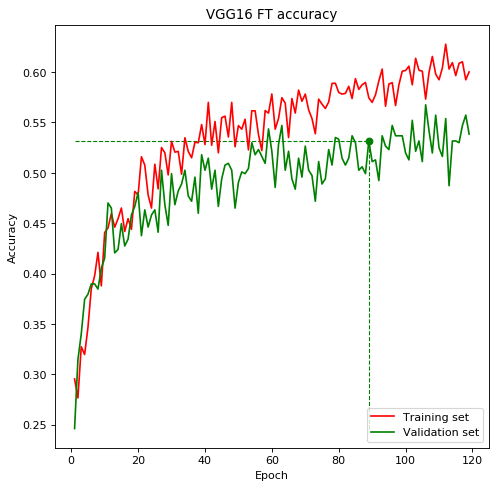

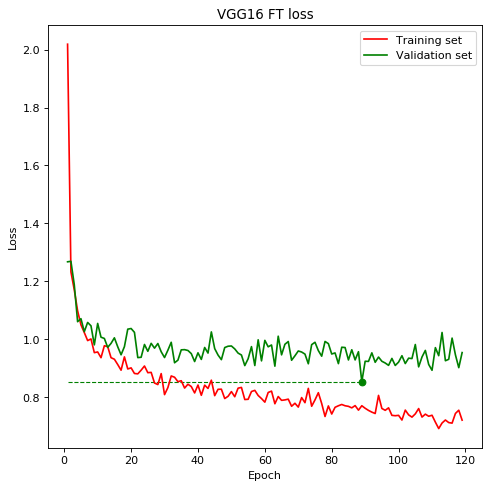

In [28]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [29]:
vgg16_calc_or_mass_best_SGD = create_vgg16(dropout=0.5, fc_size=128, output = 4)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [30]:
# Train
history_vgg16_calc_or_mass_best_SGD = vgg16_calc_or_mass_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.8033 - recall: 0.2340
Epoch 00001: val_loss improved from inf to 1.98196, saving model to ../model/vgg16_calc_or_mass_best_SGD.h5
11/11 [==============================] - 21s 2s/step - loss: 2.7661 - recall: 0.2310 - val_loss: 1.9820 - val_recall: 0.1248
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 2.3464 - recall: 0.1969
Epoch 00002: val_loss improved from 1.98196 to 1.89623, saving model to ../model/vgg16_calc_or_mass_best_SGD.h5
11/11 [==============================] - 22s 2s/step - loss: 2.3581 - recall: 0.1925 - val_loss: 1.8962 - val_recall: 0.2205
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 2.3041 - recall: 0.2148
Epoch 00003: val_loss did not improve from 1.89623
11/11 [==============================] - 21s 2s/step - loss: 2.2988 - recall: 0.2202 - val_loss: 1.9292 - val

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6787 - recall: 0.2625
Epoch 00028: val_loss did not improve from 1.39619
11/11 [==============================] - 22s 2s/step - loss: 1.6795 - recall: 0.2578 - val_loss: 1.4070 - val_recall: 0.2650
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 1.7548 - recall: 0.2625
Epoch 00029: val_loss did not improve from 1.39619
11/11 [==============================] - 21s 2s/step - loss: 1.7648 - recall: 0.2614 - val_loss: 1.4708 - val_recall: 0.2530
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6653 - recall: 0.2828
Epoch 00030: val_loss did not improve from 1.39619
11/11 [==============================] - 21s 2s/step - loss: 1.6611 - recall: 0.2791 - val_loss: 1.4626 - val_recall: 0.2308
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6524 - recall: 0.2753
Epoch 00031: val_loss did not improve from 1.39619
11/11 [==============================] - 21s 

11/11 [==============================] - 22s 2s/step - loss: 1.5047 - recall: 0.2736 - val_loss: 1.2963 - val_recall: 0.2274
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 1.5175 - recall: 0.2635
Epoch 00058: val_loss did not improve from 1.29629
11/11 [==============================] - 22s 2s/step - loss: 1.5124 - recall: 0.2698 - val_loss: 1.3116 - val_recall: 0.2239
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6050 - recall: 0.2609
Epoch 00059: val_loss did not improve from 1.29629
11/11 [==============================] - 22s 2s/step - loss: 1.6032 - recall: 0.2568 - val_loss: 1.3088 - val_recall: 0.2325
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4473 - recall: 0.2652
Epoch 00060: val_loss did not improve from 1.29629
11/11 [==============================] - 22s 2s/step - loss: 1.4443 - recall: 0.2675 - val_loss: 1.3424 - val_recall: 0.2274
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - l

Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4804 - recall: 0.2820
Epoch 00087: val_loss did not improve from 1.21863
11/11 [==============================] - 22s 2s/step - loss: 1.4841 - recall: 0.2834 - val_loss: 1.3280 - val_recall: 0.2103
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3152 - recall: 0.2778
Epoch 00088: val_loss did not improve from 1.21863
11/11 [==============================] - 22s 2s/step - loss: 1.3364 - recall: 0.2751 - val_loss: 1.2373 - val_recall: 0.2137
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4566 - recall: 0.2702
Epoch 00089: val_loss did not improve from 1.21863
11/11 [==============================] - 22s 2s/step - loss: 1.4501 - recall: 0.2690 - val_loss: 1.2588 - val_recall: 0.2188
Epoch 90/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3770 - recall: 0.2781
Epoch 00090: val_loss did not improve from 1.21863
11/11 [==============================] - 23s 

Epoch 117/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3499 - recall: 0.2797
Epoch 00117: val_loss did not improve from 1.20828
11/11 [==============================] - 23s 2s/step - loss: 1.3441 - recall: 0.2791 - val_loss: 1.2305 - val_recall: 0.2325
Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4040 - recall: 0.2618
Epoch 00118: val_loss did not improve from 1.20828
11/11 [==============================] - 22s 2s/step - loss: 1.3948 - recall: 0.2606 - val_loss: 1.2106 - val_recall: 0.2188
Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3294 - recall: 0.2672
Epoch 00119: val_loss did not improve from 1.20828
11/11 [==============================] - 23s 2s/step - loss: 1.3274 - recall: 0.2635 - val_loss: 1.2162 - val_recall: 0.2274
Epoch 120/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4734 - recall: 0.2492
Epoch 00120: val_loss improved from 1.20828 to 1.20241, saving model to ../model/vgg16_calc_

Epoch 176/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3747 - recall: 0.2677
Epoch 00176: val_loss did not improve from 1.13633
11/11 [==============================] - 22s 2s/step - loss: 1.3629 - recall: 0.2667 - val_loss: 1.1696 - val_recall: 0.2667
Epoch 177/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3002 - recall: 0.2904
Epoch 00177: val_loss did not improve from 1.13633
11/11 [==============================] - 22s 2s/step - loss: 1.2947 - recall: 0.2865 - val_loss: 1.2085 - val_recall: 0.2205
Epoch 178/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2574 - recall: 0.2896
Epoch 00178: val_loss did not improve from 1.13633
11/11 [==============================] - 22s 2s/step - loss: 1.2719 - recall: 0.2774 - val_loss: 1.1869 - val_recall: 0.2530
Epoch 179/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2524 - recall: 0.2609
Epoch 00179: val_loss did not improve from 1.13633
11/11 [==============================] - 

10/11 [==========================>...] - ETA: 1s - loss: 1.2607 - recall: 0.2820
Epoch 00206: val_loss did not improve from 1.13470
11/11 [==============================] - 23s 2s/step - loss: 1.2638 - recall: 0.2812 - val_loss: 1.2060 - val_recall: 0.2581
Epoch 207/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2990 - recall: 0.2781
Epoch 00207: val_loss did not improve from 1.13470
11/11 [==============================] - 22s 2s/step - loss: 1.3113 - recall: 0.2720 - val_loss: 1.1364 - val_recall: 0.2513
Epoch 208/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3353 - recall: 0.2781
Epoch 00208: val_loss did not improve from 1.13470
11/11 [==============================] - 22s 2s/step - loss: 1.3215 - recall: 0.2770 - val_loss: 1.1948 - val_recall: 0.2855
Epoch 209/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2441 - recall: 0.2963
Epoch 00209: val_loss did not improve from 1.13470
11/11 [==============================] - 21s 2s/step - 

In [31]:
models.save_model(vgg16_calc_or_mass_best_SGD, '../model/vgg16_calc_or_mass_end_SGD.h5')

In [32]:
tra_loss_fe = history_vgg16_calc_or_mass_best_SGD.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_SGD.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_SGD.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_SGD.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 calc or mass

Epoch [end]: 249
Epoch [opt]: 219
Valid accuracy [end]: 0.2684
Valid accuracy [opt]: 0.2752
Test accuracy [end]:  0.3297
Test accuracy [opt]:  0.3250
Valid loss [end]: 1.1116
Valid loss [opt]: 1.1007
Test loss [end]:  1.1536
Test loss [opt]:  1.1776


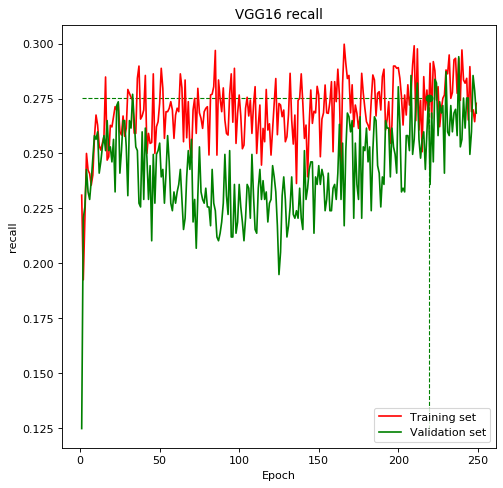

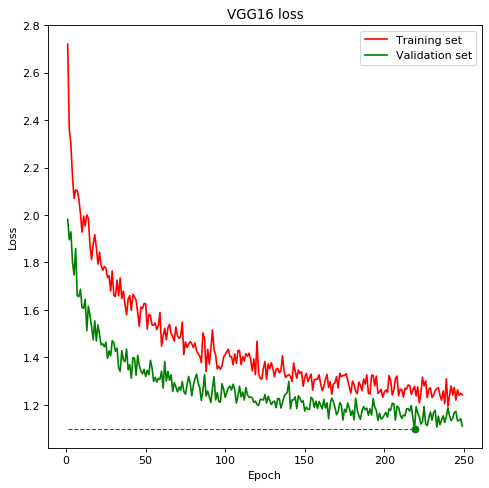

In [33]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_vgg16_calc_or_mass_best_RMSprop = vgg16_calc_or_mass_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 3.1930 - recall: 0.2156
Epoch 00001: val_loss improved from inf to 1.28973, saving model to ../model/vgg16_calc_or_mass_best_RMSprop.h5
11/11 [==============================] - 26s 2s/step - loss: 3.0143 - recall: 0.2131 - val_loss: 1.2897 - val_recall: 0.1556
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2639 - recall: 0.1759
Epoch 00002: val_loss improved from 1.28973 to 1.15048, saving model to ../model/vgg16_calc_or_mass_best_RMSprop.h5
11/11 [==============================] - 21s 2s/step - loss: 1.2674 - recall: 0.1809 - val_loss: 1.1505 - val_recall: 0.2667
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1728 - recall: 0.2617
Epoch 00003: val_loss did not improve from 1.15048
11/11 [==================

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7803 - recall: 0.5523
Epoch 00057: val_loss did not improve from 0.90366
11/11 [==============================] - 22s 2s/step - loss: 0.7849 - recall: 0.5469 - val_loss: 0.9425 - val_recall: 0.5009
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8107 - recall: 0.5522
Epoch 00058: val_loss did not improve from 0.90366
11/11 [==============================] - 22s 2s/step - loss: 0.8123 - recall: 0.5509 - val_loss: 0.9704 - val_recall: 0.5179
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7927 - recall: 0.5617
Epoch 00059: val_loss did not improve from 0.90366
11/11 [==============================] - 23s 2s/step - loss: 0.8003 - recall: 0.5533 - val_loss: 1.0070 - val_recall: 0.5111
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8009 - recall: 0.5412
Epoch 00060: val_loss did not improve from 0.90366
11/11 [==============================] - 21s 

In [17]:
models.save_model(vgg16_calc_or_mass_best_RMSprop, '../model/vgg16_calc_or_mass_end_RMSprop.h5')

In [18]:
tra_loss_fe = history_vgg16_calc_or_mass_best_RMSprop.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_RMSprop.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_RMSprop.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_RMSprop.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 calc or mass

Epoch [end]: 70
Epoch [opt]: 40
Valid accuracy [end]: 0.5077
Valid accuracy [opt]: 0.4974
Test accuracy [end]:  0.5241
Test accuracy [opt]:  0.4977
Valid loss [end]: 1.0278
Valid loss [opt]: 0.9037
Test loss [end]:  0.8918
Test loss [opt]:  0.8940


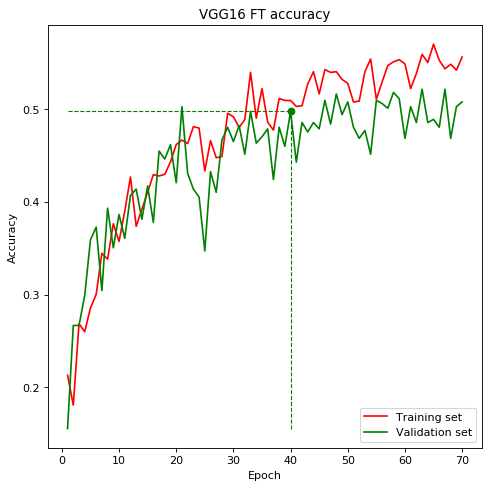

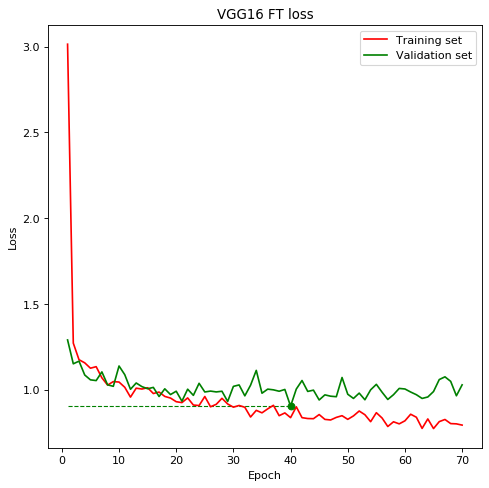

In [19]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [20]:
vgg16_calc_or_mass_best_Adadelta = create_vgg16(dropout=0.5, fc_size=128, output = 4)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [21]:
# Train
history_vgg16_calc_or_mass_best_Adadelta = vgg16_calc_or_mass_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.5215 - recall: 0.1886
Epoch 00001: val_loss improved from inf to 1.97061, saving model to ../model/vgg16_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 22s 2s/step - loss: 2.5262 - recall: 0.1877 - val_loss: 1.9706 - val_recall: 0.1897
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 2.6200 - recall: 0.1995
Epoch 00002: val_loss did not improve from 1.97061
11/11 [==============================] - 21s 2s/step - loss: 2.6088 - recall: 0.1976 - val_loss: 2.0088 - val_recall: 0.1658
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 2.5520 - recall: 0.1953
Epoch 00003: val_loss improved from 1.97061 to 1.88935, saving model to ../model/vgg16_calc_or_mass_best_Adadelta.h5
11/11 [==============================] - 23s 2s/step - loss: 2.5931 - recall: 0.1915 - val_loss: 1.

Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 2.3308 - recall: 0.2079
Epoch 00030: val_loss did not improve from 1.65950
11/11 [==============================] - 22s 2s/step - loss: 2.3244 - recall: 0.2120 - val_loss: 1.8571 - val_recall: 0.1761
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 2.2958 - recall: 0.2214
Epoch 00031: val_loss did not improve from 1.65950
11/11 [==============================] - 22s 2s/step - loss: 2.3004 - recall: 0.2188 - val_loss: 1.9384 - val_recall: 0.1556
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 2.3687 - recall: 0.1961
Epoch 00032: val_loss did not improve from 1.65950
11/11 [==============================] - 23s 2s/step - loss: 2.3996 - recall: 0.1903 - val_loss: 1.9078 - val_recall: 0.1726
Epoch 33/300
10/11 [==========================>...] - ETA: 1s - loss: 2.2586 - recall: 0.2214
Epoch 00033: val_loss did not improve from 1.65950
11/11 [==============================] - 21s 

In [22]:
models.save_model(vgg16_calc_or_mass_best_Adadelta, '../model/vgg16_calc_or_mass_end_Adadelta.h5')

In [23]:
tra_loss_fe = history_vgg16_calc_or_mass_best_Adadelta.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_Adadelta.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_Adadelta.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_Adadelta.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 calc or mass

Epoch [end]: 56
Epoch [opt]: 26
Valid accuracy [end]: 0.2154
Valid accuracy [opt]: 0.1932
Test accuracy [end]:  0.2659
Test accuracy [opt]:  0.2224
Valid loss [end]: 1.7802
Valid loss [opt]: 1.6595
Test loss [end]:  1.9178
Test loss [opt]:  1.9769


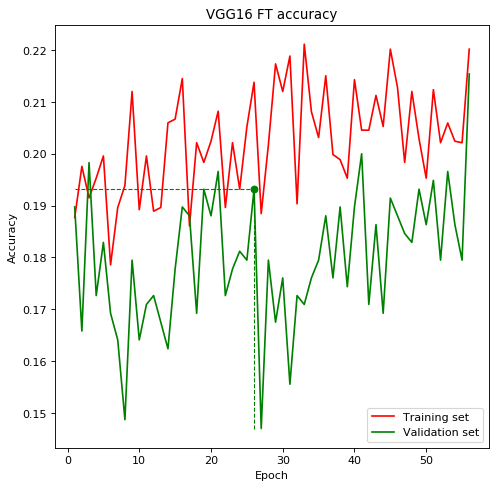

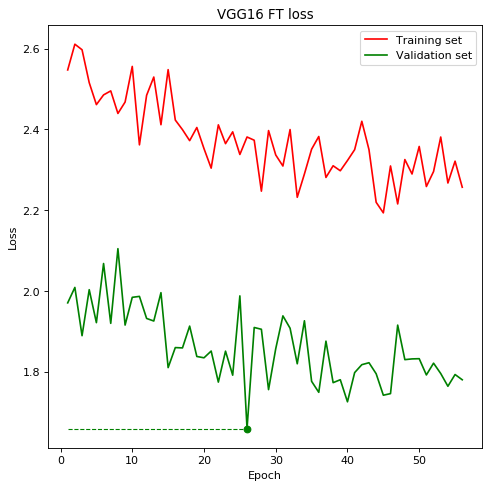

In [24]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [25]:
vgg16_calc_or_mass_best_Adagrad = create_vgg16(dropout=0.5, fc_size=128, output = 4)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [26]:
# Train
history_vgg16_calc_or_mass_best_Adagrad = vgg16_calc_or_mass_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.7097 - recall: 0.2273
Epoch 00001: val_loss improved from inf to 1.82596, saving model to ../model/vgg16_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 23s 2s/step - loss: 2.6435 - recall: 0.2337 - val_loss: 1.8260 - val_recall: 0.2427
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 2.3096 - recall: 0.2273
Epoch 00002: val_loss did not improve from 1.82596
11/11 [==============================] - 23s 2s/step - loss: 2.2993 - recall: 0.2273 - val_loss: 1.8700 - val_recall: 0.2017
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 2.2612 - recall: 0.2273
Epoch 00003: val_loss improved from 1.82596 to 1.72750, saving model to ../model/vgg16_calc_or_mass_best_Adagrad.h5
11/11 [==============================] - 22s 2s/step - loss: 2.2389 - recall: 0.2302 - val_loss: 1.72

Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6112 - recall: 0.3250
Epoch 00029: val_loss did not improve from 1.26474
11/11 [==============================] - 23s 2s/step - loss: 1.6047 - recall: 0.3274 - val_loss: 1.2707 - val_recall: 0.3026
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 1.5510 - recall: 0.3156
Epoch 00030: val_loss did not improve from 1.26474
11/11 [==============================] - 22s 2s/step - loss: 1.5457 - recall: 0.3139 - val_loss: 1.3256 - val_recall: 0.3094
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 1.5036 - recall: 0.3308
Epoch 00031: val_loss did not improve from 1.26474
11/11 [==============================] - 22s 2s/step - loss: 1.5059 - recall: 0.3313 - val_loss: 1.2952 - val_recall: 0.2991
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 1.5306 - recall: 0.3039
Epoch 00032: val_loss improved from 1.26474 to 1.22025, saving model to ../model/vgg16_calc_or_m

Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4005 - recall: 0.3207
Epoch 00059: val_loss did not improve from 1.12830
11/11 [==============================] - 22s 2s/step - loss: 1.4048 - recall: 0.3207 - val_loss: 1.1707 - val_recall: 0.3179
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4346 - recall: 0.3133
Epoch 00060: val_loss did not improve from 1.12830
11/11 [==============================] - 23s 2s/step - loss: 1.4308 - recall: 0.3161 - val_loss: 1.2148 - val_recall: 0.2957
Epoch 61/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4114 - recall: 0.3190
Epoch 00061: val_loss did not improve from 1.12830
11/11 [==============================] - 21s 2s/step - loss: 1.4355 - recall: 0.3138 - val_loss: 1.2115 - val_recall: 0.2991
Epoch 62/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3693 - recall: 0.3273
Epoch 00062: val_loss did not improve from 1.12830
11/11 [==============================] - 22s 

In [27]:
models.save_model(vgg16_calc_or_mass_best_Adagrad, '../model/vgg16_calc_or_mass_end_Adagrad.h5')

In [28]:
tra_loss_fe = history_vgg16_calc_or_mass_best_Adagrad.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_Adagrad.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_Adagrad.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_Adagrad.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 calc or mass

Epoch [end]: 74
Epoch [opt]: 44
Valid accuracy [end]: 0.3094
Valid accuracy [opt]: 0.2940
Test accuracy [end]:  0.3297
Test accuracy [opt]:  0.3110
Valid loss [end]: 1.2056
Valid loss [opt]: 1.1283
Test loss [end]:  1.2699
Test loss [opt]:  1.3360


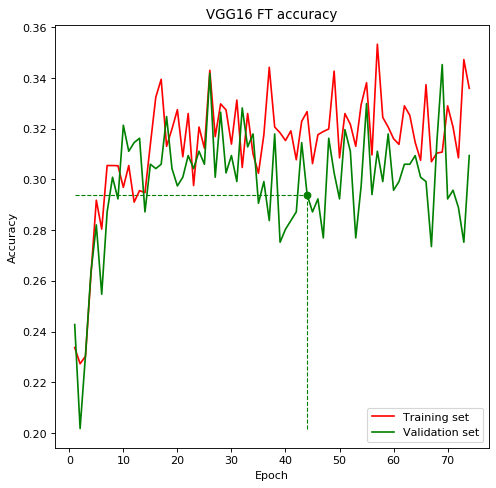

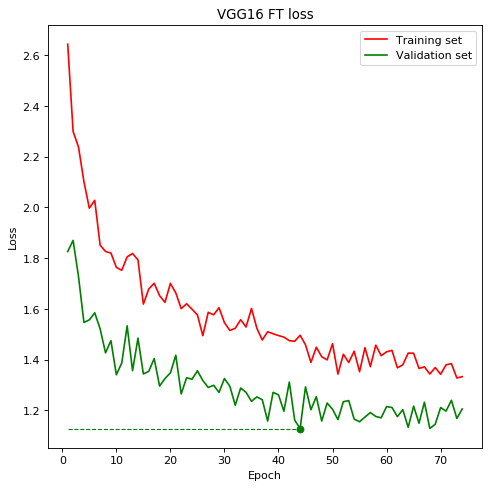

In [29]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [13]:
vgg16_calc_or_mass_best_Adamax = create_vgg16(dropout=0.5, fc_size=128, output = 4)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg16_calc_or_mass_best_Adamax = vgg16_calc_or_mass_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.4149 - recall: 0.2945
Epoch 00001: val_loss improved from inf to 1.59888, saving model to ../model/vgg16_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 27s 2s/step - loss: 2.3268 - recall: 0.3040 - val_loss: 1.5989 - val_recall: 0.2462
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6548 - recall: 0.3016
Epoch 00002: val_loss improved from 1.59888 to 1.47770, saving model to ../model/vgg16_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 23s 2s/step - loss: 1.6516 - recall: 0.3033 - val_loss: 1.4777 - val_recall: 0.2564
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4992 - recall: 0.2773
Epoch 00003: val_loss improved from 1.47770 to 1.27592, saving model to ../mod

Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0297 - recall: 0.3805
Epoch 00027: val_loss did not improve from 1.00978
11/11 [==============================] - 21s 2s/step - loss: 1.0331 - recall: 0.3830 - val_loss: 1.0180 - val_recall: 0.3385
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1205 - recall: 0.3586
Epoch 00028: val_loss improved from 1.00978 to 0.99815, saving model to ../model/vgg16_calc_or_mass_best_Adamax.h5
11/11 [==============================] - 24s 2s/step - loss: 1.1160 - recall: 0.3551 - val_loss: 0.9982 - val_recall: 0.3795
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0142 - recall: 0.3880
Epoch 00029: val_loss did not improve from 0.99815
11/11 [==============================] - 22s 2s/step - loss: 1.0205 - recall: 0.3875 - val_loss: 1.0406 - val_recall: 0.3624
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0693 - recall: 0.3544
Epoch 00030: val_loss improved f

Epoch 56/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0221 - recall: 0.3969
Epoch 00056: val_loss did not improve from 0.93392
11/11 [==============================] - 22s 2s/step - loss: 1.0140 - recall: 0.3984 - val_loss: 0.9568 - val_recall: 0.3880
Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9718 - recall: 0.4099
Epoch 00057: val_loss did not improve from 0.93392
11/11 [==============================] - 22s 2s/step - loss: 0.9780 - recall: 0.4096 - val_loss: 0.9726 - val_recall: 0.3897
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0086 - recall: 0.4040
Epoch 00058: val_loss did not improve from 0.93392
11/11 [==============================] - 22s 2s/step - loss: 1.0108 - recall: 0.4103 - val_loss: 0.9788 - val_recall: 0.3761
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0069 - recall: 0.4164
Epoch 00059: val_loss did not improve from 0.93392
11/11 [==============================] - 23s 

Epoch 86/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9798 - recall: 0.4066
Epoch 00086: val_loss did not improve from 0.89699
11/11 [==============================] - 22s 2s/step - loss: 0.9782 - recall: 0.4126 - val_loss: 0.8971 - val_recall: 0.4359
Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9686 - recall: 0.4156
Epoch 00087: val_loss did not improve from 0.89699
11/11 [==============================] - 24s 2s/step - loss: 0.9661 - recall: 0.4126 - val_loss: 0.9261 - val_recall: 0.3949
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9352 - recall: 0.4217
Epoch 00088: val_loss did not improve from 0.89699
11/11 [==============================] - 21s 2s/step - loss: 0.9432 - recall: 0.4202 - val_loss: 0.9272 - val_recall: 0.4308
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9766 - recall: 0.4219
Epoch 00089: val_loss did not improve from 0.89699
11/11 [==============================] - 22s 

Epoch 116/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9300 - recall: 0.4539
Epoch 00116: val_loss did not improve from 0.88514
11/11 [==============================] - 23s 2s/step - loss: 0.9320 - recall: 0.4545 - val_loss: 0.8930 - val_recall: 0.4530
Epoch 117/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8947 - recall: 0.4621
Epoch 00117: val_loss did not improve from 0.88514
11/11 [==============================] - 21s 2s/step - loss: 0.9024 - recall: 0.4612 - val_loss: 0.9100 - val_recall: 0.4701
Epoch 118/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8977 - recall: 0.4503
Epoch 00118: val_loss did not improve from 0.88514
11/11 [==============================] - 22s 2s/step - loss: 0.8910 - recall: 0.4559 - val_loss: 0.9247 - val_recall: 0.4085
Epoch 119/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9363 - recall: 0.4242
Epoch 00119: val_loss improved from 0.88514 to 0.87950, saving model to ../model/vgg16_calc_

Epoch 146/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8770 - recall: 0.4571
Epoch 00146: val_loss did not improve from 0.87403
11/11 [==============================] - 22s 2s/step - loss: 0.8881 - recall: 0.4506 - val_loss: 0.9220 - val_recall: 0.4769
Epoch 147/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8838 - recall: 0.4689
Epoch 00147: val_loss did not improve from 0.87403
11/11 [==============================] - 22s 2s/step - loss: 0.8867 - recall: 0.4658 - val_loss: 0.9234 - val_recall: 0.4667
Epoch 148/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8795 - recall: 0.4806
Epoch 00148: val_loss did not improve from 0.87403
11/11 [==============================] - 22s 2s/step - loss: 0.8755 - recall: 0.4780 - val_loss: 0.9033 - val_recall: 0.4376
Epoch 149/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9058 - recall: 0.4411
Epoch 00149: val_loss did not improve from 0.87403
11/11 [==============================] - 

Epoch 176/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8863 - recall: 0.4938
Epoch 00176: val_loss did not improve from 0.86254
11/11 [==============================] - 23s 2s/step - loss: 0.8847 - recall: 0.4957 - val_loss: 0.8821 - val_recall: 0.4667
Epoch 177/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8715 - recall: 0.4984
Epoch 00177: val_loss did not improve from 0.86254
11/11 [==============================] - 22s 2s/step - loss: 0.8663 - recall: 0.4993 - val_loss: 0.8910 - val_recall: 0.4615
Epoch 178/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8279 - recall: 0.5177
Epoch 00178: val_loss did not improve from 0.86254
11/11 [==============================] - 21s 2s/step - loss: 0.8273 - recall: 0.5152 - val_loss: 0.9031 - val_recall: 0.4650
Epoch 179/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8793 - recall: 0.4867
Epoch 00179: val_loss did not improve from 0.86254
11/11 [==============================] - 

In [15]:
models.save_model(vgg16_calc_or_mass_best_Adamax, '../model/vgg16_calc_or_mass_end_Adamax.h5')

In [16]:
tra_loss_fe = history_vgg16_calc_or_mass_best_Adamax.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_Adamax.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_Adamax.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_Adamax.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 calc or mass

Epoch [end]: 182
Epoch [opt]: 152
Valid accuracy [end]: 0.4786
Valid accuracy [opt]: 0.4598
Test accuracy [end]:  0.4961
Test accuracy [opt]:  0.4883
Valid loss [end]: 0.9100
Valid loss [opt]: 0.8625
Test loss [end]:  0.8318
Test loss [opt]:  0.8443


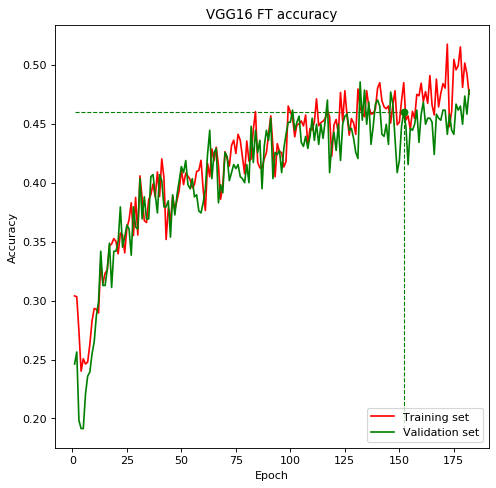

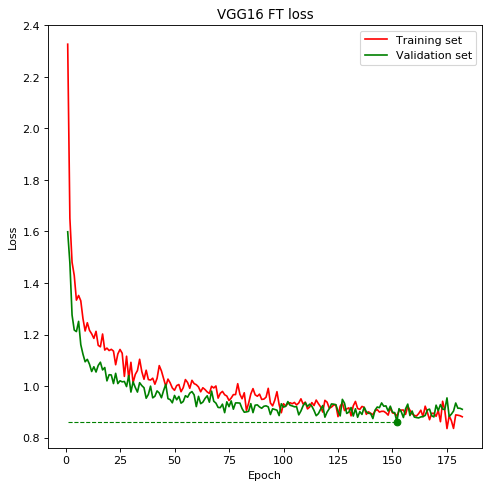

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [13]:
vgg16_calc_or_mass_best_Nadam = create_vgg16(dropout=0.5, fc_size=128, output = 4)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_calc_or_mass_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_calc_or_mass_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg16_calc_or_mass_best_Nadam = vgg16_calc_or_mass_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.4922 - recall: 0.2836
Epoch 00001: val_loss improved from inf to 1.69746, saving model to ../model/vgg16_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 27s 2s/step - loss: 2.5075 - recall: 0.2819 - val_loss: 1.6975 - val_recall: 0.3521
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.8307 - recall: 0.3367
Epoch 00002: val_loss improved from 1.69746 to 1.34200, saving model to ../model/vgg16_calc_or_mass_best_Nadam.h5
11/11 [==============================] - 21s 2s/step - loss: 1.8186 - recall: 0.3397 - val_loss: 1.3420 - val_recall: 0.2650
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4647 - recall: 0.3172
Epoch 00003: val_loss improved from 1.34200 to 1.23210, saving model to ../model

10/11 [==========================>...] - ETA: 1s - loss: 1.0056 - recall: 0.4192
Epoch 00026: val_loss did not improve from 0.89333
11/11 [==============================] - 22s 2s/step - loss: 0.9989 - recall: 0.4217 - val_loss: 0.9310 - val_recall: 0.4325
Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9799 - recall: 0.4234
Epoch 00027: val_loss did not improve from 0.89333
11/11 [==============================] - 23s 2s/step - loss: 0.9799 - recall: 0.4219 - val_loss: 0.9530 - val_recall: 0.3829
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9808 - recall: 0.4125
Epoch 00028: val_loss did not improve from 0.89333
11/11 [==============================] - 22s 2s/step - loss: 0.9755 - recall: 0.4162 - val_loss: 0.9271 - val_recall: 0.4034
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9434 - recall: 0.4250
Epoch 00029: val_loss did not improve from 0.89333
11/11 [==============================] - 22s 2s/step - los

Epoch 56/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9056 - recall: 0.4562
Epoch 00056: val_loss did not improve from 0.84823
11/11 [==============================] - 22s 2s/step - loss: 0.8988 - recall: 0.4567 - val_loss: 0.8801 - val_recall: 0.4530
Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8882 - recall: 0.4883
Epoch 00057: val_loss did not improve from 0.84823
11/11 [==============================] - 23s 2s/step - loss: 0.8804 - recall: 0.4929 - val_loss: 0.9292 - val_recall: 0.4427
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9233 - recall: 0.4602
Epoch 00058: val_loss did not improve from 0.84823
11/11 [==============================] - 22s 2s/step - loss: 0.9195 - recall: 0.4616 - val_loss: 0.9017 - val_recall: 0.4427
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9171 - recall: 0.4697
Epoch 00059: val_loss did not improve from 0.84823
11/11 [==============================] - 22s 

In [15]:
models.save_model(vgg16_calc_or_mass_best_Nadam, '../model/vgg16_calc_or_mass_end_Nadam.h5')

In [16]:
tra_loss_fe = history_vgg16_calc_or_mass_best_Nadam.history['loss']
tra_acc_fe = history_vgg16_calc_or_mass_best_Nadam.history['recall']
val_loss_fe = history_vgg16_calc_or_mass_best_Nadam.history['val_loss']
val_acc_fe = history_vgg16_calc_or_mass_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_calc_or_mass = models.load_model('../model/vgg16_calc_or_mass_best_Nadam.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("VGG16 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 calc or mass

Epoch [end]: 84
Epoch [opt]: 54
Valid accuracy [end]: 0.4564
Valid accuracy [opt]: 0.4632
Test accuracy [end]:  0.4883
Test accuracy [opt]:  0.4650
Valid loss [end]: 0.9171
Valid loss [opt]: 0.8482
Test loss [end]:  0.8569
Test loss [opt]:  0.8523


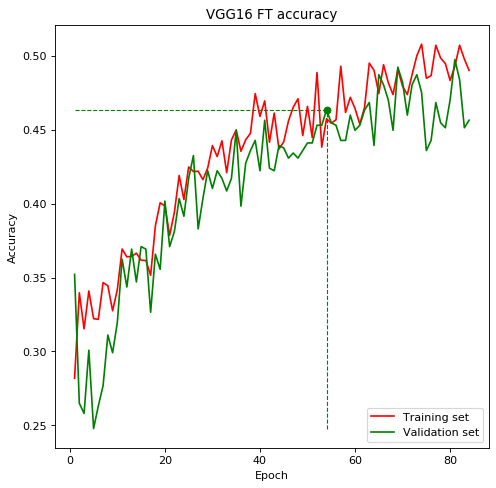

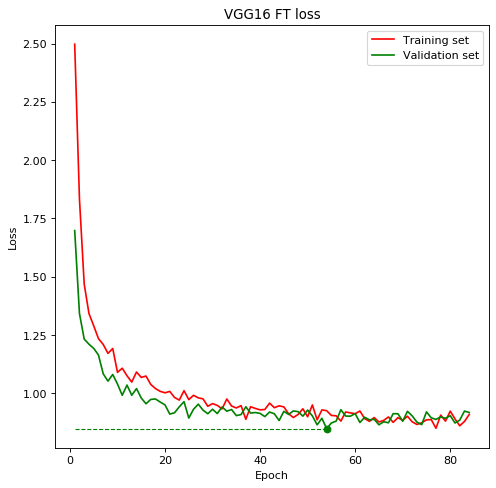

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [ ]:
vgg16_calc_or_mass_fine_Adam = models.load_model('../model/vgg16_calc_or_mass_best_Adam.h5')

for layer in vgg16_calc_or_mass_fine_Adam.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_calc_or_mass_fine_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_calc_or_mass_fine_Adam.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_calc_or_mass_fine_Adam_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [ ]:
history_fit = vgg16_calc_or_mass_fine_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
models.save_model(vgg16_calc_or_mass_fine_Adam, '../model/vgg16_calc_or_mass_fine_Adam_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_calc_or_mass_fine_Adam = models.load_model('../model/vgg16_calc_or_mass_fine_Adam_best.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
vgg16_calc_or_mass_fine_Adam2 = models.load_model('../model/vgg16_calc_or_mass_fine_Adam_best.h5')

for layer in vgg16_calc_or_mass_fine_Adam2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_calc_or_mass_fine_Adam2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_calc_or_mass_fine_Adam.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_calc_or_mass_fine_Adam_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [ ]:
history_fit = vgg16_calc_or_mass_fine_Adam2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
models.save_model(vgg16_calc_or_mass_fine_Adam2, '../model/vgg16_calc_or_mass_fine_Adam_end2.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_calc_or_mass_fine_Adam2 = models.load_model('../model/vgg16_calc_or_mass_fine_Adam_best2.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
vgg16_calc_or_mass_fine_Adam3 = models.load_model('../model/vgg16_calc_or_mass_fine_Adam_best2.h5')

for layer in vgg16_calc_or_mass_fine_Adam3.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_calc_or_mass_fine_Adam3.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_calc_or_mass_fine_Adam3.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_calc_or_mass_fine_Adam_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [ ]:
history_fit = vgg16_calc_or_mass_fine_Adam3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
models.save_model(vgg16_calc_or_mass_fine_Adam3, '../model/vgg16_calc_or_mass_fine_Adam_end3.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_calc_or_mass_fine_Adam3 = models.load_model('../model/vgg16_calc_or_mass_fine_Adam_best3.h5')
test_loss_fe, test_acc_fe = vgg16_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();